# **주요 내용**

*   다중 입력 모델 구현간 가능한 방법은 2가지이다. 그 중에서도, 2번의 방법으로 우선 실험한다.

    1. pre-emphasis만 수행된 데이터를 raw audio data와 합쳐서 training
    2. pre-emphasis data와 raw audio data를 각각 훈련한 다음 결과를 연결하여 분류기 추가
*   concatenate (길이 2N=N+N) 대신 merge (길이 N) 하였을 때의 결괏값 확인 - add()
    *   https://keras.io/api/layers/merging_layers/

In [1]:
notebookName = "20200508_7"
notebookName

'20200508_7'

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0-rc4'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9655757928467310097, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6228957272314969538
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8746815752834642727
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17576117089530852257
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [5]:
!nvidia-smi

Fri May  8 10:19:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    37W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [7]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['GSF06742CKA0', 'GSF05432KSY0', 'GSM05953CJH0', 'GSM02434AGS0', 'I4F02631KSM0']
50


***.pcm to *.wav**

In [8]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    print("{}\t{}".format(i, folder_path))

    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

0	GSF03031LJH0
1	GSF03732JJH0
2	GSF04122LHK0
3	GSF04524CJI0
4	GSF04623LWJ0
5	GSF04923PEY0
6	GSF05134JHK0
7	GSF05432KSY0
8	GSF05733HBH0
9	GSF05844LJR0
10	GSF06654KES0
11	GSF06742CKA0
12	GSF06833JYK0
13	GSF06934SYN0
14	GSF07132LCY0
15	GSF08142LDH0
16	GSF08233NEH0
17	GSF08333KJH0
18	GSF09025WYY0
19	GSF09431SHY0
20	GSF09844KKS0
21	GSM02434AGS0
22	GSM02544LHS0
23	GSM03224CHD0
24	GSM03321SDK0
25	GSM03634SJY0
26	GSM03823YJK0
27	GSM04233KMS0
28	GSM04424JBRC
29	GSM05953CJH0
30	GSM06044JBY0
31	GSM06235BJH0
32	GSM07042NSK0
33	GSM07355MIW0
34	GSM09534JHD0
35	GSM09644KCK0
36	GSM09752SCY0
37	I4F02224SDY0
38	I4F02631KSM0
39	I4F02821YRR0
40	I4F02933JSI0
41	I4F03423KSR0
42	I4F03543KSY0
43	I4F03922LKY0
44	I4F04732OIY0
45	I4F05332CJH0
46	I4F05625JSY0
47	I4F07443LJA0
48	I4F07633JSI0
49	I4F07852PKJ0


In [0]:
import numpy as np

num_labels = 50
num_features = 100
data_length = 3 ** 9   # 19,683

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [10]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, data_length))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 19683), train_labels.shape: (4000,)
test_data.shape: (1000, 19683), test_labels.shape: (1000,)


**train data, validation data 분할 및 전처리 (normalization)**

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

random_state = 1234
test_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels,
                                                  test_size = test_size,
                                                  random_state = random_state) # fixed

x_train = X_train.reshape(len(X_train), data_length, 1)
x_val = X_val.reshape(len(X_val), data_length, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

In [12]:
print("test_size: {}, random_state: {}\n".format(test_size, random_state))
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

test_size: 0.2, random_state: 1234

x_train.shape: (3200, 19683, 1), y_train.shape: (3200, 50)
x_val.shape: (800, 19683, 1), y_val.shape: (800, 50)


**Build (Advanced) Model**

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

num_blocks = 4
base = 3        # base of data_length

raw_audio_input = Input(shape = (data_length, 1), name = 'raw_audio')

# Build Model with raw audio input - branch x
x = layers.Conv1D(name = "x_block_1_conv", filters = 16, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(raw_audio_input)
x = layers.MaxPooling1D(name = "x_block1_pool", pool_size = 3)(x)
x = layers.BatchNormalization(name = "x_block1_norm")(x)

x = layers.Conv1D(name = "x_block2_conv", filters = 32, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(x)
x = layers.MaxPooling1D(name = "x_block2_pool", pool_size = 3)(x)
x = layers.BatchNormalization(name = "x_block2_norm")(x)

x = layers.Conv1D(name = "x_block3_conv", filters = 64, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(x)
x = layers.MaxPooling1D(name = "x_block3_pool", pool_size = 3)(x)
x = layers.BatchNormalization(name = "x_block3_norm")(x)

x = layers.Conv1D(name = "x_block4_conv", filters = 128, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(x)
x = layers.MaxPooling1D(name = "x_block4_pool", pool_size = 3)(x)
x = layers.BatchNormalization(name = "x_block4_norm")(x)

x = layers.GlobalAveragePooling1D(name = "x_GAP")(x)

# Build Model with pre-emphasized audio input - branch y
y = layers.Conv1D(name = "y_pre_emp_conv", filters = 1, kernel_size = 2, strides = 1, 
                  padding = "same", activation = 'relu')(raw_audio_input)
y = layers.MaxPooling1D(name = "y_block1_pool", pool_size = 3)(y)
y = layers.BatchNormalization(name = "y_block1_norm")(y)

y = layers.Conv1D(name = "y_block2_conv", filters = 32, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(y)
y = layers.MaxPooling1D(name = "y_block2_pool", pool_size = 3)(y)
y = layers.BatchNormalization(name = "y_block2_norm")(y)

y = layers.Conv1D(name = "y_block3_conv", filters = 64, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(y)
y = layers.MaxPooling1D(name = "y_block3_pool", pool_size = 3)(y)
y = layers.BatchNormalization(name = "y_block3_norm")(y)

y = layers.Conv1D(name = "y_block4_conv", filters = 128, kernel_size = 3, strides = 1, 
                  padding = "same", activation = 'relu')(y)
y = layers.MaxPooling1D(name = "y_block4_pool", pool_size = 3)(y)
y = layers.BatchNormalization(name = "y_block4_norm")(y)

y = layers.GlobalAveragePooling1D(name = "y_GAP")(y)

In [0]:
# Merged - Average()
added = layers.Add(name = 'added')([x, y])
out = layers.Dense(num_labels, activation = 'softmax', name = "dense")(added)

model = Model(raw_audio_input, out, name = 'model')

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_audio (InputLayer)          [(None, 19683, 1)]   0                                            
__________________________________________________________________________________________________
x_block_1_conv (Conv1D)         (None, 19683, 16)    64          raw_audio[0][0]                  
__________________________________________________________________________________________________
y_pre_emp_conv (Conv1D)         (None, 19683, 1)     3           raw_audio[0][0]                  
__________________________________________________________________________________________________
x_block1_pool (MaxPooling1D)    (None, 6561, 16)     0           x_block_1_conv[0][0]             
______________________________________________________________________________________________

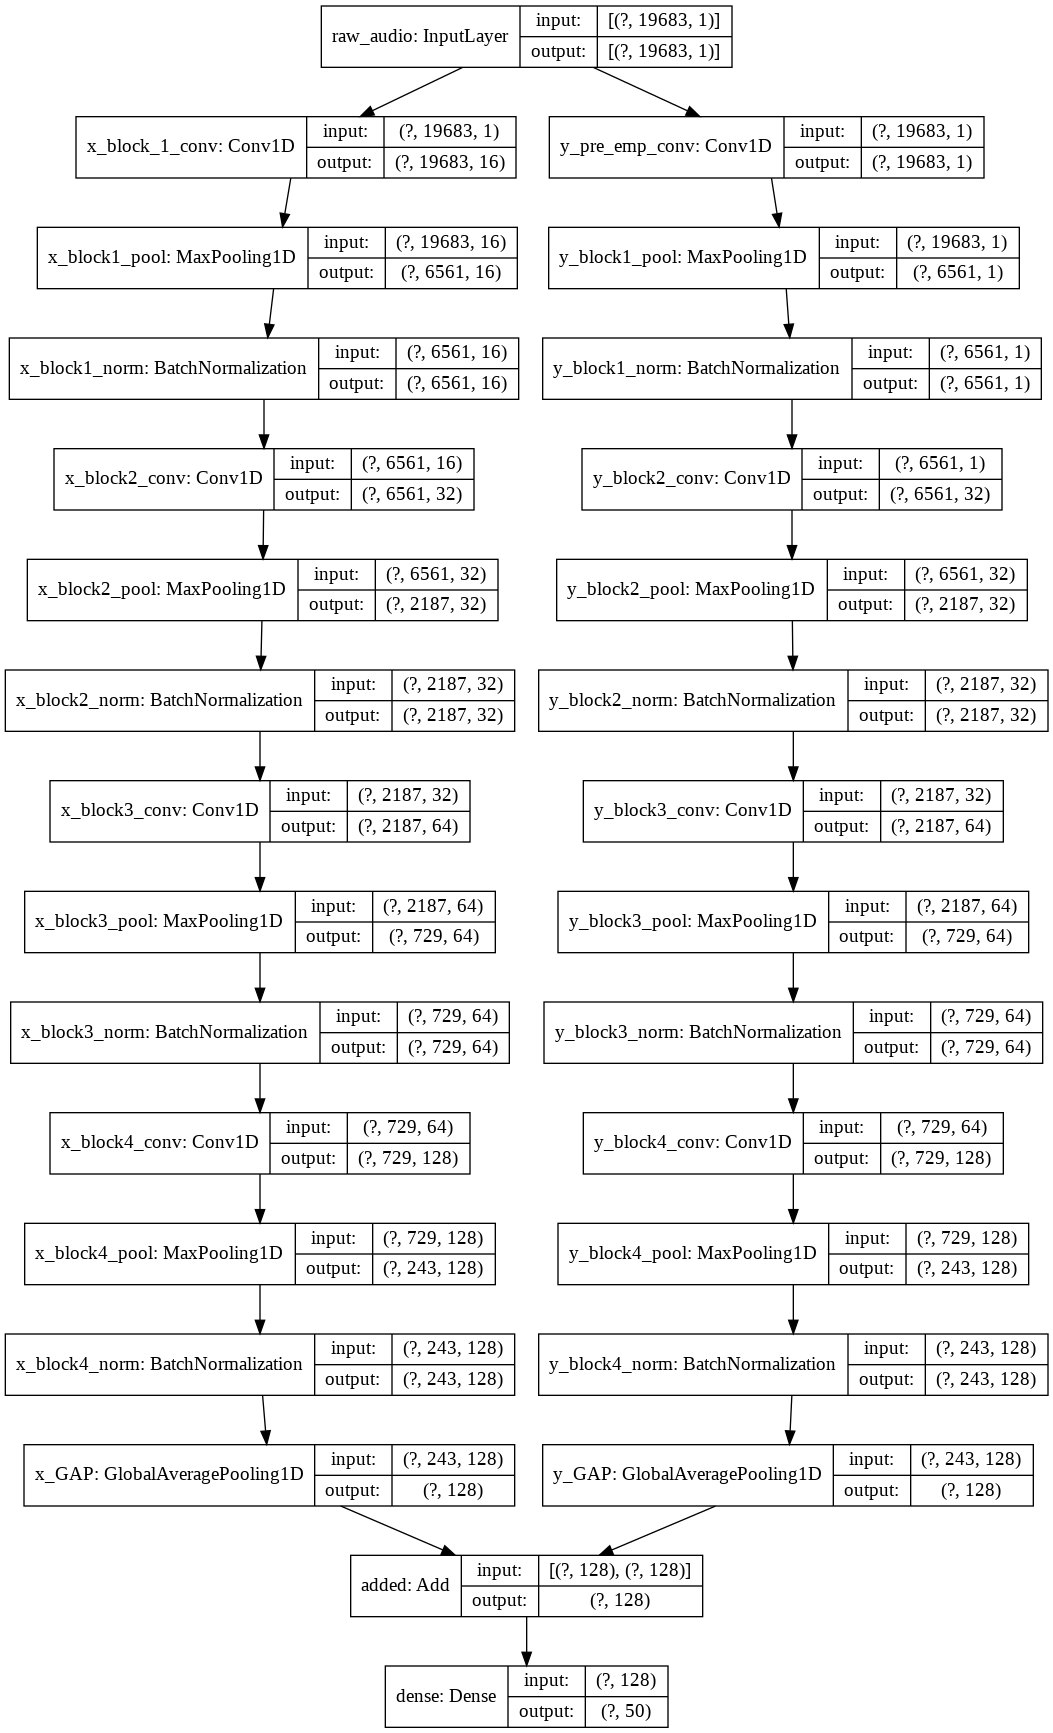

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True, to_file = 'model.png')

**Initialize the weights and bias of y_pre_emp_conv layer**

In [17]:
for l in model.layers:
    print("{:<15}: ".format(l.name), end = "")

    ws = [str(w.shape) for w in l.get_weights() if l.get_weights()] if l.get_weights() else ["None"]
    print(" ".join(ws))

raw_audio      : None
x_block_1_conv : (3, 1, 16) (16,)
y_pre_emp_conv : (2, 1, 1) (1,)
x_block1_pool  : None
y_block1_pool  : None
x_block1_norm  : (16,) (16,) (16,) (16,)
y_block1_norm  : (1,) (1,) (1,) (1,)
x_block2_conv  : (3, 16, 32) (32,)
y_block2_conv  : (3, 1, 32) (32,)
x_block2_pool  : None
y_block2_pool  : None
x_block2_norm  : (32,) (32,) (32,) (32,)
y_block2_norm  : (32,) (32,) (32,) (32,)
x_block3_conv  : (3, 32, 64) (64,)
y_block3_conv  : (3, 32, 64) (64,)
x_block3_pool  : None
y_block3_pool  : None
x_block3_norm  : (64,) (64,) (64,) (64,)
y_block3_norm  : (64,) (64,) (64,) (64,)
x_block4_conv  : (3, 64, 128) (128,)
y_block4_conv  : (3, 64, 128) (128,)
x_block4_pool  : None
y_block4_pool  : None
x_block4_norm  : (128,) (128,) (128,) (128,)
y_block4_norm  : (128,) (128,) (128,) (128,)
x_GAP          : None
y_GAP          : None
added          : None
dense          : (128, 50) (50,)


In [18]:
w = model.layers[2].get_weights()[0] # weight
b = model.layers[2].get_weights()[1] # bias

print(w, b)

[[[0.70842445]]

 [[0.28643668]]] [0.]


In [0]:
w[0][0][0] = -0.97
w[1][0][0] = 1.

b[0] = 0.

In [0]:
model.layers[2].set_weights([w, b])

In [21]:
model.layers[2].get_weights()

[array([[[-0.97]],
 
        [[ 1.  ]]], dtype=float32), array([0.], dtype=float32)]

**Train model**

In [0]:
# compile
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [23]:
import time

batch_size = 80
epochs = 500

print("Train on {} samples, validate on {} samples...".format(x_train.shape[0], x_val.shape[0]))

start = time.time()
print("[  start time] {}".format(time.strftime('%c', time.localtime(time.time()))))
history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 0)
end = time.time()
print("[    end time] {}".format(time.strftime('%c', time.localtime(time.time()))))
print("[working time] {:.2f} (sec)".format(end - start))

Train on 3200 samples, validate on 800 samples...
[  start time] Fri May  8 10:23:40 2020
[    end time] Fri May  8 10:42:13 2020
[working time] 1113.70 (sec)


**모델 및 결과 저장**

In [24]:
save_model_path = "/content/drive/My Drive/models"
save_results_path = "/content/drive/My Drive/results"

if not os.path.exists(save_model_path):     os.mkdir(save_model_path)
if not os.path.exists(save_results_path):   os.mkdir(save_results_path)

model.save(os.path.join(save_model_path, notebookName + ".h5"))

np.savez_compressed(os.path.join(save_results_path, notebookName),
                    accuracy = history.history['accuracy'],
                    val_accuracy = history.history['val_accuracy'],
                    loss = history.history['loss'],
                    val_loss = history.history['val_loss'])

# name
print("save_file_name: {}".format(notebookName))

save_file_name: 20200508_7


**히스토리 출력**

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


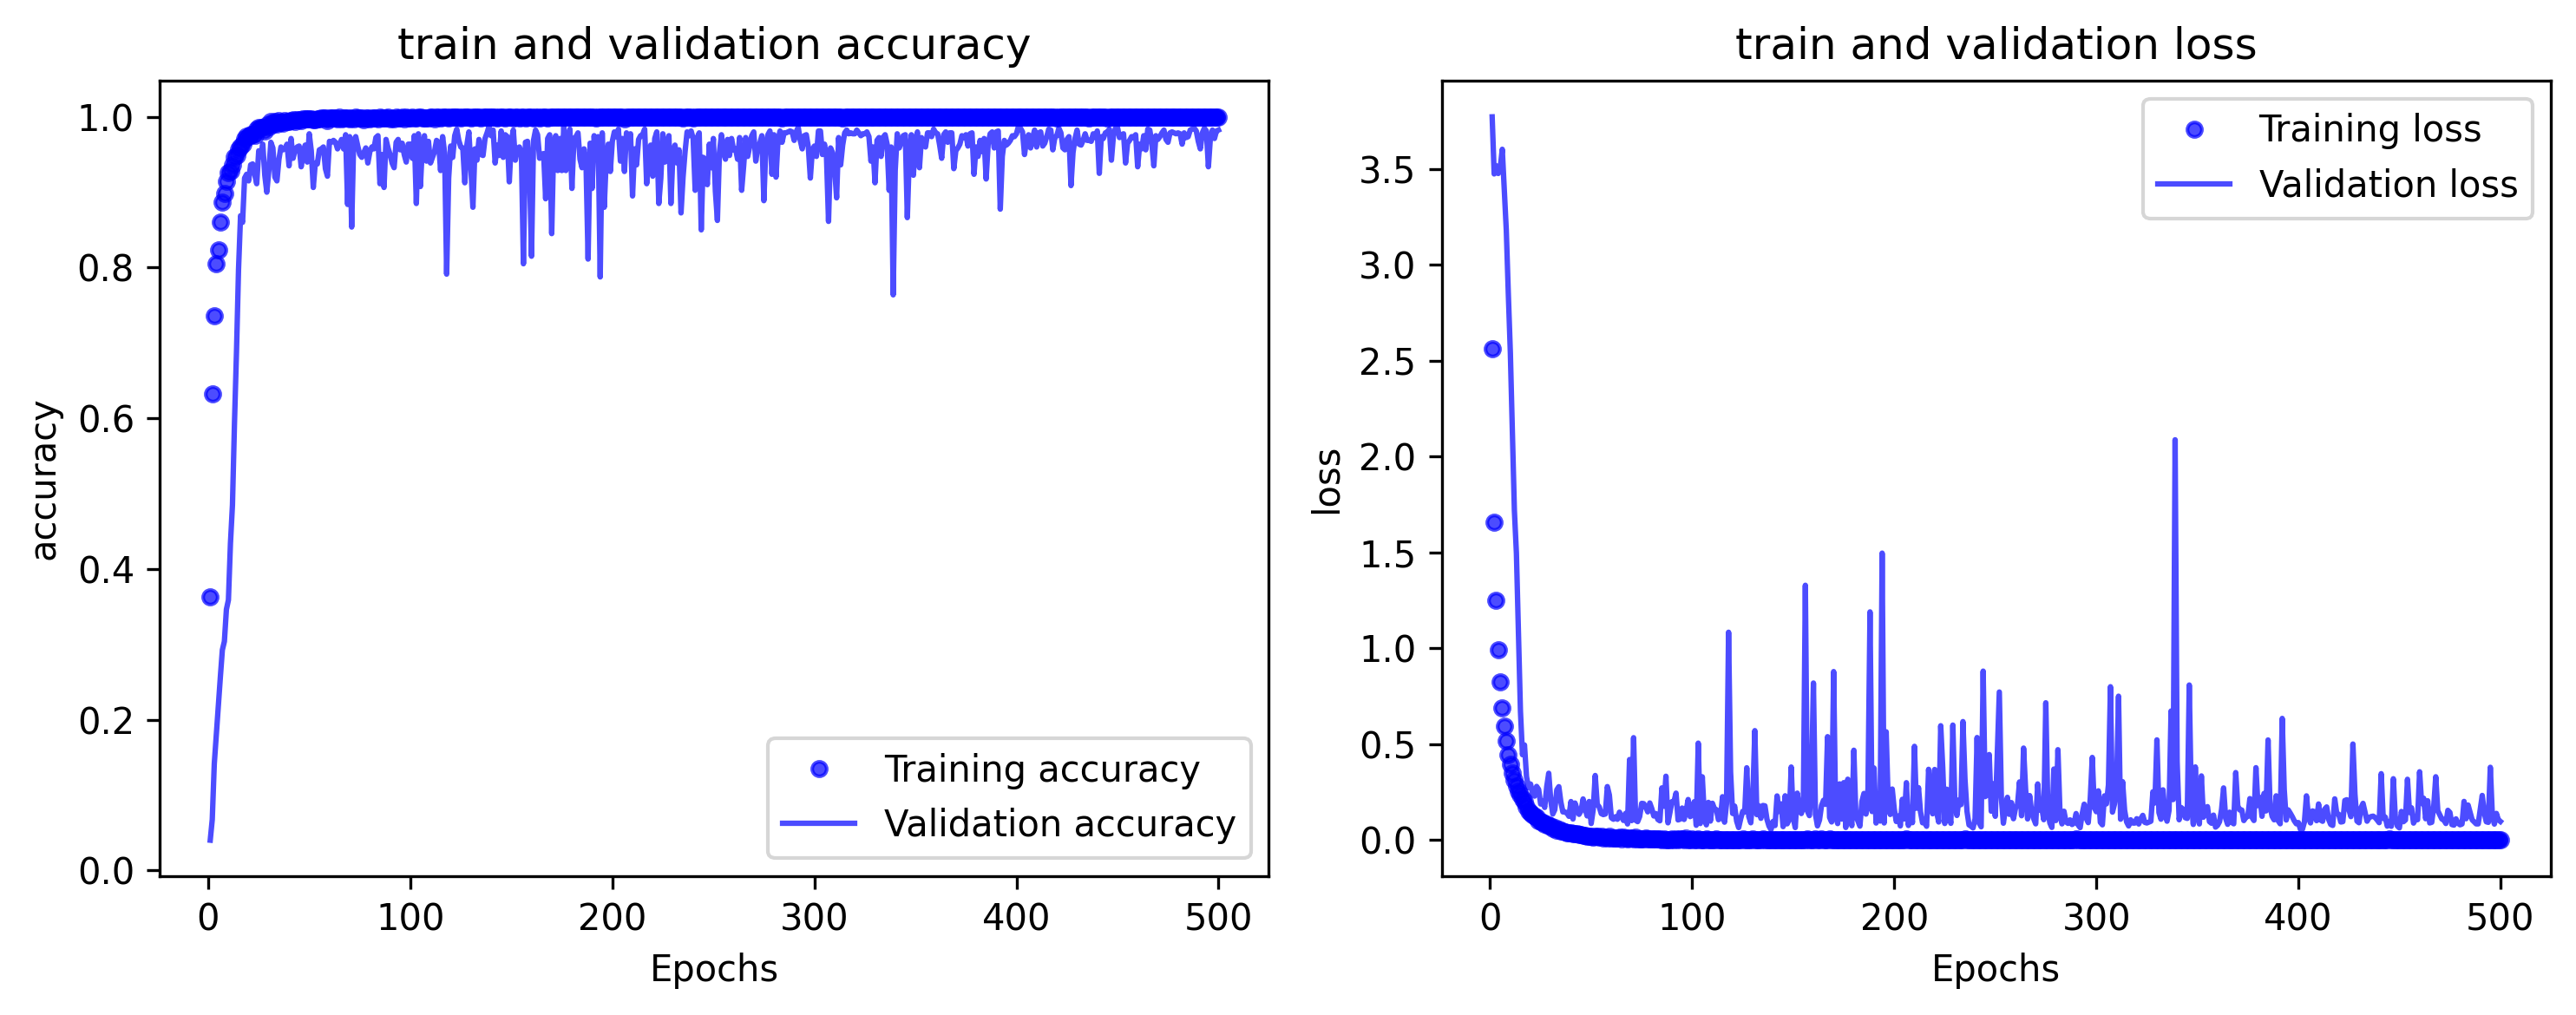

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(np.arange(1, len(acc) + 1, 1), acc, 'bo', label = 'Training accuracy', ms = 4, alpha = .7)
plt.plot(np.arange(1, len(val_acc) + 1, 1), val_acc, 'b', label = 'Validation accuracy', alpha = .7)
plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(np.arange(1, len(loss) + 1, 1), loss, 'bo', label = 'Training loss', ms = 4, alpha = .7)
plt.plot(np.arange(1, len(val_loss) + 1, 1), val_loss, 'b', label = 'Validation loss', alpha = .7)
plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

**test data를 통해 identification model 최종 평가 (field test)**

In [27]:
# reshaping
del test_data, test_labels

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

test_data = test_data.reshape(len(test_data), data_length, 1)
test_labels = to_categorical(test_labels)

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 19683, 1), test_labels.shape: (1000, 50)


In [28]:
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

13/13 [==============================] - 0s 21ms/step - loss: 0.0592 - accuracy: 0.9890
test loss, test acc: [0.05921509489417076, 0.9890000224113464]


**초기 설정했던 pre-emphasis의 가중치 변화 확인**

*   weight: [-0.97, 1] → [-0.89, 1.09]
*   bias: [0] → [1.23]

In [29]:
model.layers[2].get_weights()

[array([[[-0.8854578]],
 
        [[ 1.0854658]]], dtype=float32), array([1.2302109], dtype=float32)]